In [6]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

from cityscapes import Cityscapes, printImageLabel

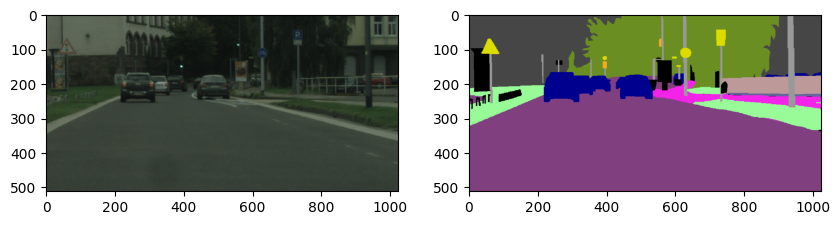

In [5]:
crop_width = 1024
crop_height = 512
composed = T.Compose([T.ToTensor(), T.RandomHorizontalFlip(p=0.5), T.RandomAffine(0, scale=[0.75, 2.0]), T.RandomCrop((crop_height, crop_width), pad_if_needed=True)])
train_data = Cityscapes("./data/Cityscapes", "images/", "labels/", train=True, info_file="info.json", transforms=composed)
val_data = Cityscapes("./data/Cityscapes", "images/", "labels/", train=False, info_file="info.json", transforms=composed)
image, label = train_data[0]
printImageLabel(image, label)

In [11]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)